Imports

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc

In [29]:
df = pd.read_csv("Fraud.csv")
print("Shape:", df.shape)
df.head()

Shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [30]:
print(df.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [31]:
for col in df.columns:
    unique_vals = df[col].nunique()
    print(f"{col}: {unique_vals} unique values")

step: 743 unique values
type: 5 unique values
amount: 5316900 unique values
nameOrig: 6353307 unique values
oldbalanceOrg: 1845844 unique values
newbalanceOrig: 2682586 unique values
nameDest: 2722362 unique values
oldbalanceDest: 3614697 unique values
newbalanceDest: 3555499 unique values
isFraud: 2 unique values
isFlaggedFraud: 2 unique values


In [32]:
merchant_sender = df["nameOrig"].str.startswith("M").sum()
customer_sender = df["nameOrig"].str.startswith("C").sum()

print("Sender Accounts:")
print("Merchants:", merchant_sender)
print("Customers:", customer_sender)

# Count for receiver accounts
merchant_receiver = df["nameDest"].str.startswith("M").sum()
customer_receiver = df["nameDest"].str.startswith("C").sum()

print("\nReceiver Accounts:")
print("Merchants:", merchant_receiver)
print("Customers:", customer_receiver)

Sender Accounts:
Merchants: 0
Customers: 6362620

Receiver Accounts:
Merchants: 2151495
Customers: 4211125


In [33]:
# Create merchant flag
df["isMerchant"] = df["nameDest"].str.startswith("M").astype(int)

# Fraud counts grouped by merchant/customer
fraud_stats = df.groupby("isMerchant")[["isFraud", "isFlaggedFraud"]].sum()
total_counts = df["isMerchant"].value_counts()

fraud_stats["Total_Transactions"] = total_counts
fraud_stats["Fraud_%"] = (fraud_stats["isFraud"] / fraud_stats["Total_Transactions"]) * 100
fraud_stats["Flagged_%"] = (fraud_stats["isFlaggedFraud"] / fraud_stats["Total_Transactions"]) * 100

print(fraud_stats)


            isFraud  isFlaggedFraud  Total_Transactions   Fraud_%  Flagged_%
isMerchant                                                                  
0              8213              16             4211125  0.195031    0.00038
1                 0               0             2151495  0.000000    0.00000


In [34]:
# Filter fraud cases
fraud_cases = df[df["isFraud"] == 1]

# Count fraud transactions by type
fraud_by_type = fraud_cases["type"].value_counts()

print(fraud_by_type)


type
CASH_OUT    4116
TRANSFER    4097
Name: count, dtype: int64


ML MODELS

In [69]:
from sklearn.model_selection import train_test_split

X = df[['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 
        'oldbalanceDest', 'newbalanceDest']]
y = df['isFraud']

# Encode 'type' (categorical → numerical)
X = pd.get_dummies(X, columns=['type'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
# Handle imbalance
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]


In [70]:
model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train, y_train)

d:\projects\fraud_transaction_detection\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [19:30:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


ROC-AUC Score: 0.9994838480028728

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00   1906322
           1       0.12      1.00      0.21      2464

    accuracy                           0.99   1908786
   macro avg       0.56      0.99      0.60   1908786
weighted avg       1.00      0.99      0.99   1908786



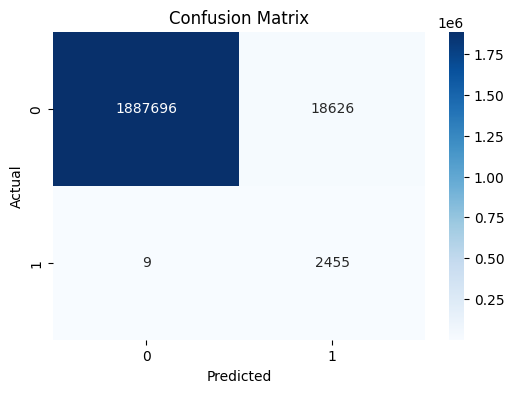

In [71]:
# y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.05).astype(int)  

# ROC-AUC Score
auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC Score:", auc)

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


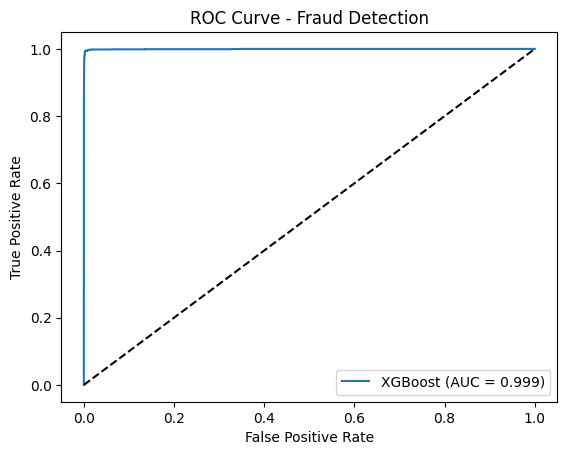

In [72]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--')  # baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Fraud Detection")
plt.legend()
plt.show()

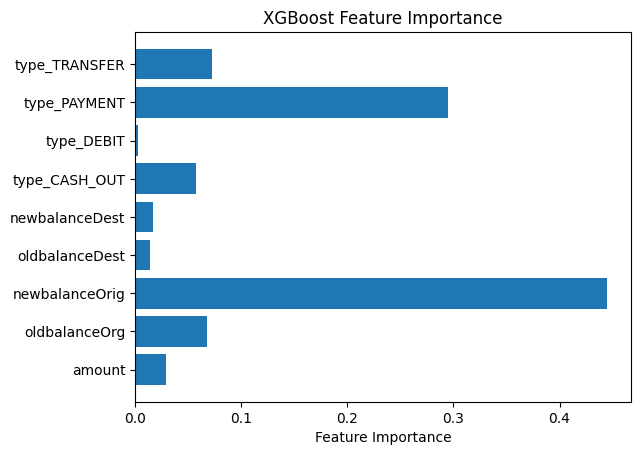

In [73]:
# Feature Importance
importances = model.feature_importances_
features = X.columns
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.show()

In [74]:
import joblib
joblib.dump(model, "xgb_fraud_model2.pkl")
print("✅ Model saved as xgb_fraud_model2.pkl")

✅ Model saved as xgb_fraud_model2.pkl


Testing with synthetically created dataset

In [45]:
import pandas as pd
import numpy as np

# Number of samples
n_samples = 10000
fraud_ratio = 0.35  # 35% fraud = 3500 cases

# Generate target variable
is_fraud = np.zeros(n_samples, dtype=int)
is_fraud[:int(n_samples * fraud_ratio)] = 1
np.random.shuffle(is_fraud)

# Transaction types (same as original dataset)
transaction_types = ["CASH_IN", "CASH_OUT", "DEBIT", "PAYMENT", "TRANSFER"]

# Generate synthetic dataset with same schema as training
df_test = pd.DataFrame({
    "type": np.random.choice(transaction_types, size=n_samples),
    "amount": np.random.uniform(10, 50000, size=n_samples).round(2),
    "oldbalanceOrg": np.random.uniform(0, 100000, size=n_samples).round(2),
    "newbalanceOrig": np.random.uniform(0, 100000, size=n_samples).round(2),
    "oldbalanceDest": np.random.uniform(0, 100000, size=n_samples).round(2),
    "newbalanceDest": np.random.uniform(0, 100000, size=n_samples).round(2),
    "isFraud": is_fraud
})

# Save to CSV
df_test.to_csv("test.csv", index=False)

print("✅ test.csv generated with shape:", df_test.shape)
print(df_test.head())


✅ test.csv generated with shape: (10000, 7)
       type    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0     DEBIT  34893.64       65461.92        37021.81        97721.63   
1   CASH_IN  46738.83       95486.64        80275.65        66470.86   
2   PAYMENT  21332.69       24849.94        12447.95        42119.83   
3  CASH_OUT   1776.84       98291.45        45361.51        85833.55   
4  CASH_OUT  29327.25       81010.86        47255.89        43613.27   

   newbalanceDest  isFraud  
0        86458.37        1  
1        94092.62        1  
2        65383.06        1  
3        12368.49        0  
4        24461.08        0  


In [77]:
import pandas as pd
import joblib

# 1. Load the saved model
model = joblib.load("xgb_fraud_model2.pkl")

# 2. Load test dataset
df_test = pd.read_csv("test.csv")


In [57]:
print(df_test.columns)

Index(['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud'],
      dtype='object')


Confusion Matrix:
 [[6495    5]
 [3497    3]]

Classification Report:
               precision    recall  f1-score   support

           0       0.65      1.00      0.79      6500
           1       0.38      0.00      0.00      3500

    accuracy                           0.65     10000
   macro avg       0.51      0.50      0.39     10000
weighted avg       0.55      0.65      0.51     10000



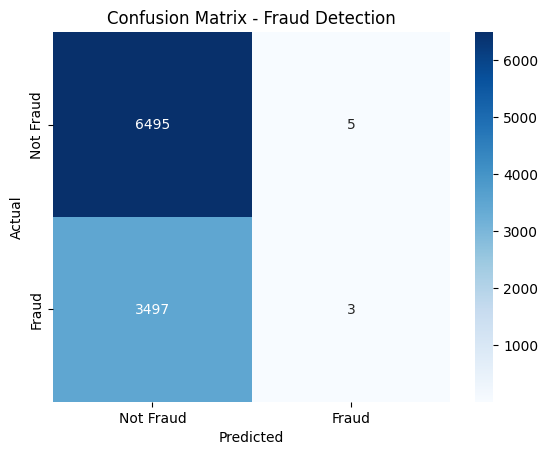

In [78]:
X_test = df_test[['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
                  'oldbalanceDest', 'newbalanceDest']]
y_test = df_test["isFraud"]

# Encode 'type' same as training
X_test = pd.get_dummies(X_test, columns=['type'], drop_first=True)

# --- Ensure same columns as training ---
for col in model.get_booster().feature_names:
    if col not in X_test.columns:
        X_test[col] = 0
X_test = X_test[model.get_booster().feature_names]

# 4. Predictions
y_pred = model.predict(X_test)

# 5. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 6. Optional: Plot heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Fraud", "Fraud"],
            yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Fraud Detection")
plt.show()

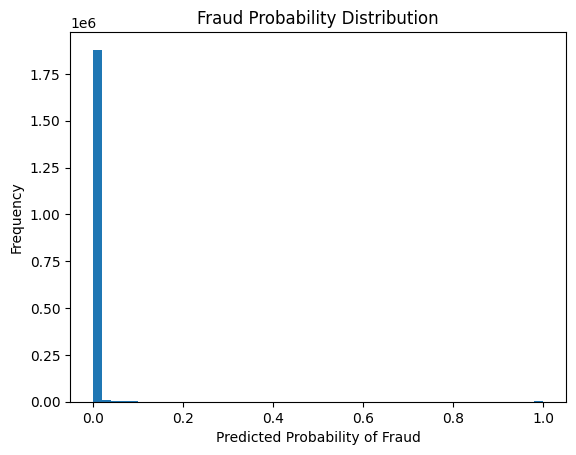

In [79]:
import matplotlib.pyplot as plt

plt.hist(y_pred_proba, bins=50)
plt.title("Fraud Probability Distribution")
plt.xlabel("Predicted Probability of Fraud")
plt.ylabel("Frequency")
plt.show()
